![Logo UOC](https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/logotips/logo-UOC-2linies.png)

# TFG - Inteligencia Artificial
Enero de 2026

## Predicción de Respuesta a Tratamientos Oncológicos Basada en el Perfil Genético Mediante Técnicas de Aprendizaje Automático (ML) e Identificación de Genes Candidatos a Biomarcador Usando Técnicas de Explicabilidad (XAI) y Cuantificación de la Incertidumbre (UQ)

---

#### Pablo Vázquez Rodríguez
##### Grado en Ingeniería Informática
##### Inteligencia Artificial

#### Dra. María Moreno de Castro
#### Dr. Friman Sánchez

---

## EDA y preparación de datos

Aunque es habitual hablar de EDA y preparación de datos como procedimientos separados, la naturaleza cíclica de CRISP-DM implica que estos dos procedimientos se retroalimentan, en especial cuando se empieza la preparación de datos. En ese momento no es raro que haya exploración durante la preparación y cierto nivel de solapamiento.


### Objetivos del Análisis exploratorio de Datos

Con el análisis exploratorio se busca entender mejor el conjunto de datos en general y así poder:
* Asegurar su integridad
* Preparar de forma informada los datos con vistas al modelado posterior
* Basar decisiones de modelado en la naturaleza y características del conjunto de datos.

Para ello se definen una serie de objetivos:
* Comprobar la forma, integridad y calidad de los datos
* Describir los datos
* Explorar relaciones
    * Estudiar la correlación entre genes
    * Analizar el potencial del dataset para separar entre respondedores y no respondedores (PCA bidimensional)
    * Explorar variabilidad de los genes

### Objetivos de la preparación de datos

La preparación de datos implica adaptar el conjunto de datos original de forma idónea para el modelado posterior, basándose en la información obtenida durante el análisis exploratorio de datos y el conocimiento del dominio.

Los objetivos principales son:
* Reducir la dimensionalidad (con base en varianza y DEG (diferencial de niveles de expresión entre respondedores y no respondedores))
* Identificar necesidad o no de normalización/estandarización según los algoritmos de modelado
* División del conjunto de datos en subconjuntos de entrenamiento, test y calibración. Como se disponen de pocos datos se usará validación cruzada en base al subconjunto de entrenamiento (por eso no hablamos de subconjunto de validación).

**NOTA**: Los dos últimos objetivos están muy relacionados con el tipo de modelado que se vaya a realizar en cada caso, así que aunque técnicamente corresponden a la preparación de datos, se dejarán para decidir en las tareas de modelado según corresponda.


## 0. Operaciones previas

### Carga de módulos necesarios

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

### Configuraciones iniciales

In [2]:
# Random generator de numpy con seed para reproducibilidad en el notebook
rng_seed = 19293
rng = np.random.default_rng(seed=rng_seed)

In [3]:
# Carga del dataset
df = pd.read_csv("data/CTR_Fluorouracil_expresion_and_response_dataset.csv")

In [4]:
# VARIABLES ÚTILES

# Nombres de las columnas de genes
gene_columns = df.columns.difference(["Sample_id", "Response"])

## 1. Forma, integridad y calidad de los datos

### Forma y características

In [5]:
# Forma
print(f"Forma: {df.shape}", end="\n\n")

# Información general
df.info()

Forma: (1889, 2396)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Columns: 2396 entries, ABCA5 to Response
dtypes: float64(2394), object(2)
memory usage: 34.5+ MB


In [6]:
df.head()

,ABCA5,ABCC3,ABCC5,ABCF1,ABCG1,ABHD2,ABHD4,ABI2,ABL2,ABTB2,...,ZNF821,ZNF862,ZNHIT2,ZSCAN18,ZSWIM1,ZWILCH,ZXDC,ZYX,Sample_id,Response
0,4.223804,5.796835,6.189211,4.997508,5.061990,6.701982,4.463019,6.976905,7.353935,4.671754,...,5.701896,5.199086,3.492723,3.276536,3.944823,5.783973,5.944751,6.362947,GSM1233067,Non_response
1,4.655241,4.888598,5.047499,5.622852,5.883654,7.068820,3.595527,7.593726,6.614329,4.839424,...,5.765843,6.409554,3.750048,4.462327,4.013077,5.142345,6.321532,7.265771,GSM1233069,Non_response
2,4.203078,5.871373,5.784834,5.628435,5.544521,7.628239,3.607586,7.489539,7.634670,4.632803,...,5.553818,5.473808,4.250198,4.616130,3.676840,4.973429,6.897971,7.247948,GSM1233072,Non_response
3,4.506262,6.660597,6.193733,6.245883,5.405675,7.281692,3.205763,7.784791,6.650528,4.911538,...,5.829469,4.525553,4.284960,3.844501,4.337754,5.012604,5.446864,8.862146,GSM1233085,Response
4,3.707333,9.160912,6.078676,5.269432,5.057008,6.959105,4.242487,7.346498,6.640292,4.662444,...,5.981552,5.897722,3.787848,3.819905,4.166846,5.067088,6.524262,7.185289,GSM1233086,Non_response


In [7]:
df.tail()

,ABCA5,ABCC3,ABCC5,ABCF1,ABCG1,ABHD2,ABHD4,ABI2,ABL2,ABTB2,...,ZNF821,ZNF862,ZNHIT2,ZSCAN18,ZSWIM1,ZWILCH,ZXDC,ZYX,Sample_id,Response
1884,4.192561,5.371228,7.507191,9.197917,5.358518,6.471157,7.428487,7.499647,6.069031,6.877148,...,6.283611,7.397283,5.657700,6.701371,5.273054,5.870024,6.273136,7.953645,GSM590890,Response
1885,4.147243,5.654129,7.200501,8.420715,5.377236,6.635265,7.637529,7.944927,6.260703,6.569280,...,6.235106,7.293589,5.592846,8.156039,5.263147,5.008757,5.845798,7.970516,GSM590894,Response
1886,4.501910,5.264016,7.565398,8.394449,5.473341,6.670330,6.952190,7.746782,6.114862,6.419077,...,5.832098,7.052938,5.722607,6.581801,5.002434,5.415442,6.036792,8.262770,GSM590896,Response
1887,4.121386,5.550229,6.353799,7.986946,5.817901,6.636420,7.547362,7.687915,6.215537,6.436918,...,6.072775,7.661015,5.890714,7.283222,5.102534,5.201266,6.631116,7.630549,GSM590898,Non_response
1888,4.412062,5.836415,7.947164,7.891023,5.944613,8.092298,7.748100,8.119109,6.097545,6.642753,...,6.128096,7.703641,5.724006,8.186593,5.424113,5.733280,5.996204,8.402665,GSM508020,Non_response


**NOTA**: Una recomendación general que es habitual para tratar de evitar sobreajustes es que los conjuntos de datos dedicados a crear modelos de aprendizaje automático tengan cerca de 100 veces más filas que columnas (n_rows > n_cols*100). El dataset original ni se acerca a esa recomendación, así que durante la preparación de datos habremos de tener eso en cuenta. Dicho eso, el número final deberá de establecerse de forma técnica y no arbitraria, usando técnicas de selección de características.

### Integridad y calidad

In [8]:
# Comprobación de valores nulos
print(df.isnull().sum().sum())

0


In [9]:
# Comprobación de vacíos en Sample_id y Response
(df[["Sample_id", "Response"]]=="").sum()

Sample_id    0
Response     0
dtype: int64

In [10]:
# Comprobación de duplicados
print(df["Sample_id"].duplicated().sum())

0


In [11]:
# Formato consistente (valores únicos esperados)
df["Response"].unique()

array(['Non_response', 'Response'], dtype=object)

Los datos están limpios, sin duplicados y con valores consistentes. 

Además, tal y como se explica en la metodología de procesado de CRT-DB [https://pmc.ncbi.nlm.nih.gov/articles/PMC8728209/] sabemos que los datos se encuentran ya normalizados.

El escalado del dataset sólo se aplicará según sea necesario para algoritmos que así lo precisen

**NOTA**: Como los datos ya están normalizados y preprocesados por CTR-DB, además de la información estadística mostrada hasta el momento, se puede asumir que los posibles valores extremos u outliers no son errores técnicos ni de medición, y que pueden tener significancia biológica. Por tanto, no se eliminarán ni se tratarán en este punto. Los posibles outliers se evaluarán y filtrarán según significancia del gen, en la exploración que se muestra más adelante en este mismo documento (exploración con PCA, reducción de dimensionalidad y selección de características).

## 2. Descripción de los datos

El dataset consta de 3 tipos de columnas:
* ***(Nombres de Genes)***: Valor numérico de la expresión del gen
* **Sample_id**: Cadena de caracteres con el identificador de la muestra
* **Responder**: Cadena de caracteres que puede tomar los valores "Response" o "Non_response", según si la muestra corresponde a una persona que respondió al tratamiento o no respectivamente.

### Análisis de la distribución de los datos

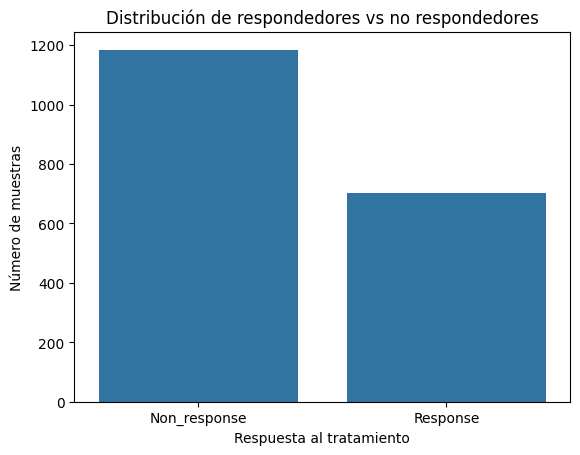

Response
Non_response    1185
Response         704
Name: count, dtype: int64


In [12]:
# Distribución variable objetivo
sns.countplot(x='Response', data=df)
plt.title("Distribución de respondedores vs no respondedores")
plt.xlabel("Respuesta al tratamiento")
plt.ylabel("Número de muestras")
plt.show()

# Conteo
print(df['Response'].value_counts())

El dataset está **moderadamente desbalanceado**. Como no es un balanceo extremo no se aplican técnicas agresivas de downsampling, oversampling, ni nada similar.

Sí que habrá de tenerse en cuenta este desbalanceo según los algoritmos usados y modelados posteriores, así como a la hora de validar y evaluar los modelos (Por ejemplo: F1-Score en clase minoritaria, ROC-AUC, etc.)


La regresión logística puede ser sensible a esta asimetría, por lo que se deberá aplicar balanceo.

Aunque los algoritmos basados en árboles son menos sensibles a esta asimetría, se puede aplicar balanceo para minimizar el riesgo de que esa asimetría afecte.

Además, se usarán métricas como AUC y/o F1-score para captar el rendimiento balanceado 

También se aplicará validación cruzada estratificada, para que cada subconjunto de datos refleje las proporciones del conjunto de datos original.

Para un dataset con tantas columnas no es práctico hacer un describe. En su lugar se calculan los datos estadísticos de todo el conjunto de genes directamente, y se hace un histograma de densidad para tener una idea de cómo se distribuyen los valores:

In [13]:
# Se convierte todo a un array plano
values = df[gene_columns].values.flatten()

# Se calculan estadísticas globales
summary = {
    "count": len(values),
    "mean": np.mean(values),
    "std": np.std(values),
    "min": np.min(values),
    "25%": np.percentile(values, 25),
    "50%": np.percentile(values, 50),
    "75%": np.percentile(values, 75),
    "max": np.max(values)
}

# Se muestra la tabla de datos
pd.DataFrame.from_dict(summary, orient="index")

,0
count,4.522266e+06
mean,7.701042e+00
std,2.149462e+00
min,-1.802199e-01
25%,6.213036e+00
50%,7.542192e+00
75%,9.077272e+00
max,1.878368e+01


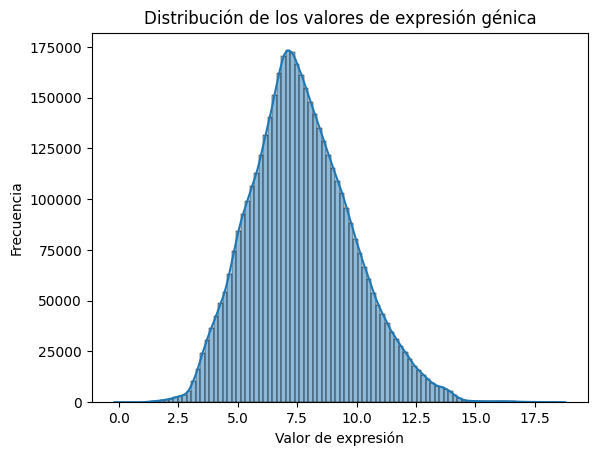

In [14]:
# Distribución de los valores de expresión génica
sns.histplot(df[gene_columns].values.flatten(), bins=100, kde=True)
plt.title("Distribución de los valores de expresión génica")
plt.xlabel("Valor de expresión")
plt.ylabel("Frecuencia")
plt.show()

El rango de valores de expresión del dataset va de -0.18 a 18.78, con centro en 7.70 y la dispersión es relativamente moderada.

Los datos según el propio paper publicado por CRT-DB [https://pmc.ncbi.nlm.nih.gov/articles/PMC8728209/] describiendo la base de datos indica que las muestras de **Microarray** se reprocesan mediante el método «Robust Multiarray Average» (RMA).
RMA consiste en un pipeline de las siguientes operaciones: Corrección de fondo + transformación logarítmica en base 2 + normalización por cuantiles + resumen. 

* La **corrección de fondo elimina ruido** de la medición realizada en el laboratorio. 
* La **transformación logarítmica en base 2** se aplica para reducir asimetrías de datos y permitir la aplicación de métodos estadísticos para comparar genes.
* **Normalización por cuantiles**: Se aplica para asegurar distribuciones de expresión comparables entre las muestras, preservando las diferencias de expresión entre genes
* **Resumen**: Las mediciones de laboratorio con múltiples sondas midiendo el mismo gen, producen resultados múltiples, que en este caso se combinan en un sólo dato de expresión por cada gen. Eso elimina redundancia y rudio.

**NOTA**: Los datos de RMA son log2, lo que implica que es poco probable obtener valores negativos (sólo para intensidades crudas de entre 0 y 1), pero no imposibles.


## 3. Exploración de relaciones

### Estudio de la correlación entre genes

Index(['ABCA5', 'ABCC3', 'ABCC5', 'ABCF1', 'ABCG1', 'ABHD2', 'ABHD4', 'ABI2',
       'ABL2', 'ABTB2',
       ...
       'ZNF770', 'ZNF771', 'ZNF821', 'ZNF862', 'ZNHIT2', 'ZSCAN18', 'ZSWIM1',
       'ZWILCH', 'ZXDC', 'ZYX'],
      dtype='object', length=2394)


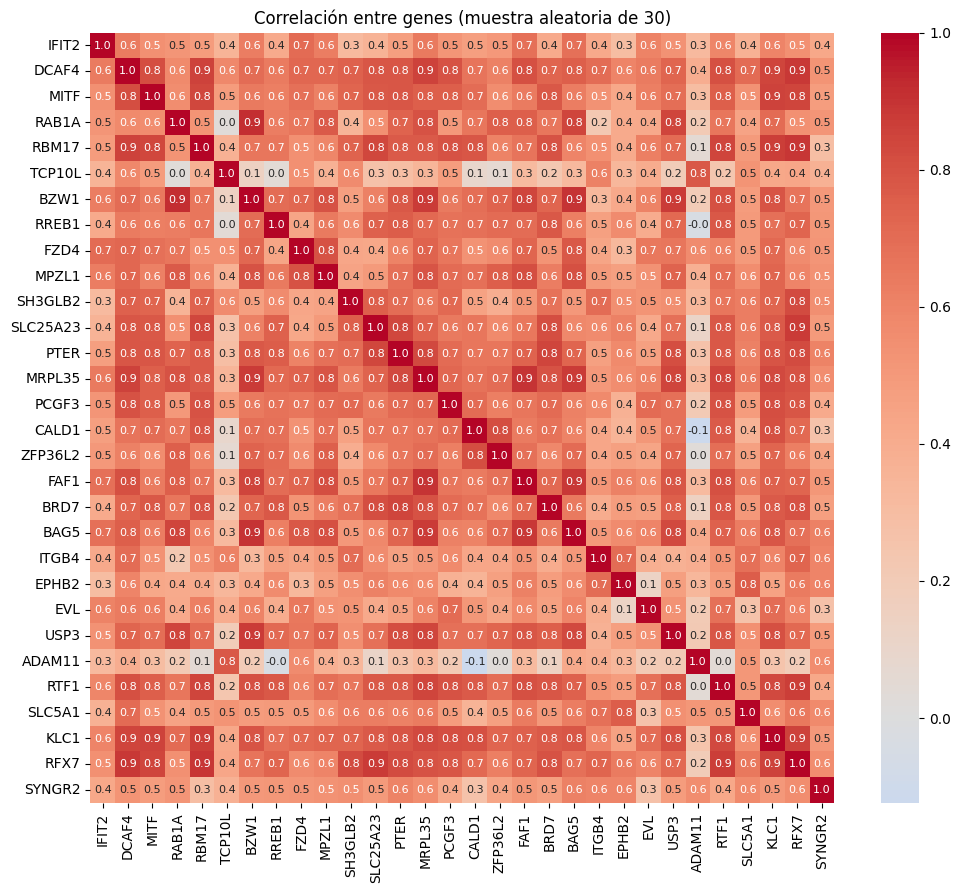

In [15]:
# Heatmap muestra aleatoria de genes
gene_columns = df.columns.difference(["Sample_id", "Response"])
print(gene_columns)
sample_genes = rng.choice(gene_columns, size=30, replace=False)
corr_matrix = df[sample_genes].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={'fontsize':8}, center=0)
plt.title("Correlación entre genes (muestra aleatoria de 30)")
plt.show()

En esa matriz de correlaciones se observa que existen genes muy correlacionados positivamente, con valores de hasta 0.9. Es habitual en transcriptómica que muchos genes se coexpresen en ciertos momentos así que es esperado encontrar este tipo de correlaciones en los datos.

No se ven correlaciones negativas significativas.

Se observan dos genes cuya expresión parece no correlacionarse con el resto (genes ADAM11 y TCP10L).

Buscando información se observa que ADAM11 [https://en.wikipedia.org/wiki/ADAM11] y TCP10L [https://en.wikipedia.org/wiki/TCP10L] tienen relación con casos de cáncer de mama y tumores hepáticos respectivamente, siendo genes que se expresan menos en ese tipo de patologías. Eso podría ser una explicación de su baja correlación con otros genes pero relativamente alta (0.8) entre ambos.

Habrá de tenerse en cuenta cómo estas correlaciones afectarán a los diferentes modelos:

* En regresión logística se habrá de tener en cuenta esta multicolinealidad por ser un algoritmo sensible a ella. Para ello es recomendable aplicar regularización, como L1, L2 o Elastic Net, para limitar el peso de los genes en casos de alta multicolinealidad, como es el caso.

* En el caso de los algoritmos basados en árboles la multicolinealidad no influye tanto en el modelado, pero si puede tener impacto en la interpretabilidad, ya que a la hora de hacer ordenaciones el peso de cada gen se puede ver repartido entre los que comparten correlación. En ese caso SHAP puede ayudar a ver contribuciones conjuntas.

La reducción de dimensionalidad y selección de características ya comentada en apartados anteriores, ayudará a rebajar el número de genes correlacionados, pero conviene tener la alta correlación en cuenta.

### Análisis de potencial del dataset para separar entre respondedores y no respondedores

Con este análisis se busca principalmente si los datos del conjunto de datos tienen algún tipo de estructura, y si esa estructura es capaz de dividir a los datos en las clases objetivo o no.

Se muestra a continuación las estructuras resultantes de graficar los 2 y 3 componentes más significativos de PCA.

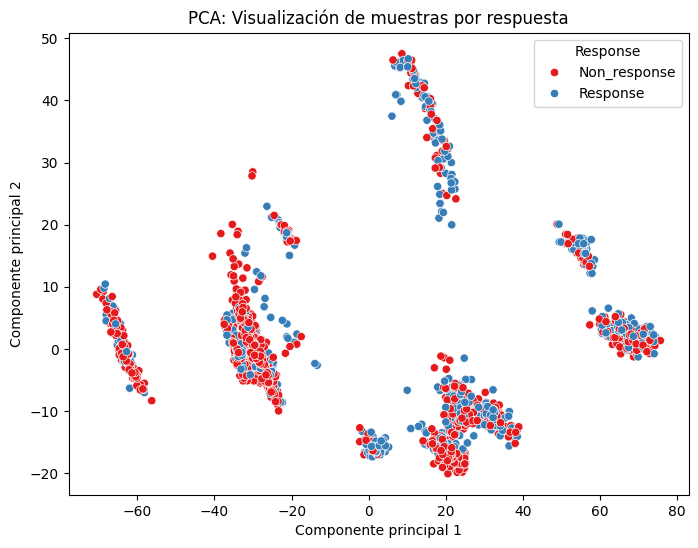

In [16]:
# PCA 2 componentes
X = df[gene_columns]
y = df['Response']

# Escalado
X_scaled = StandardScaler().fit_transform(X)

# PCA 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gráfico 2D con colores según Response
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1')
plt.title("PCA: Visualización de muestras por respuesta")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()

In [17]:
print("Varianza explicada acumulada (PCA 2 componentes):", pca.explained_variance_ratio_.cumsum()[-1])

Varianza explicada acumulada (PCA 2 componentes): 0.6957563755758762


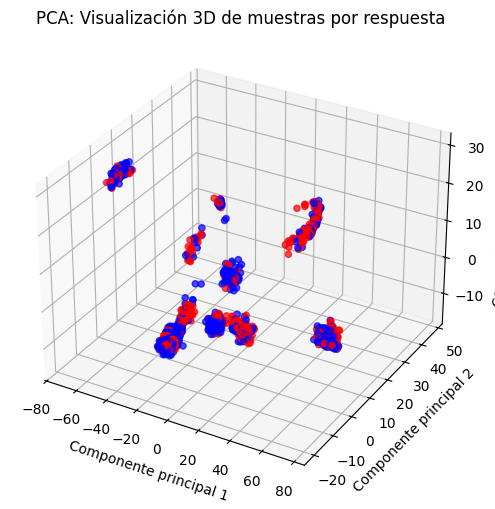

In [18]:
# PCA 3 componentes
# Datos
X = df[gene_columns]
y = df['Response']

# Colores según Response
color_data = {'Response': 'red', 'Non_response': 'blue'}
colors = [color_data[label] for label in y]

# Escalado
X_scaled = StandardScaler().fit_transform(X)

# PCA con 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Gráfico 3D
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=colors,
    alpha=0.7
)

ax.set_title("PCA: Visualización 3D de muestras por respuesta")
ax.set_xlabel("Componente principal 1")
ax.set_ylabel("Componente principal 2")
ax.set_zlabel("Componente principal 3")
plt.show()

In [19]:
print("Varianza explicada acumulada (PCA 3 componentes):", pca.explained_variance_ratio_.cumsum()[-1])

Varianza explicada acumulada (PCA 3 componentes): 0.7615733402113979


Se puede ver que los datos sí tienen estructura, aunque esta no los divide de forma lineal entre las clases objetivo de Response.

Las 8-9 agrupaciones que vemos tanto en 2 como en 3 dimensiones se podrían explicar por alguna de las siguientes razones:
* Los diferentes tipos de cáncer de los que se han recogido las muestras.
* El dataset recoge todos los datos de estudios en los que el tratamiento incluye Fluorouracil, pero cada estudio puede contener tratamientos con cócteles diferentes que impliquen respuestas diferentes.

**NOTA**: El análisis profundo de las causas que explican esos clústers fuera de este proyecto y se deja como posible actividad extraordinaria.

La conclusión que se puede extraer es que las relaciones que permiten separar entre las dos clases objetivo, si las hay, serán no lineales.

Como esa relación no es lineal, se usará a continuación un método no lineal, t-SNE, que según el artículo publicado en Nature "The art of using t-SNI for single cell transcriptomics" [https://www.nature.com/articles/s41467-019-13056-x.pdf] es muy relevante a la hora de mostrar estructuras subyacentes en datos de alta dimensionalidad. [https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding]

El t‑Distributed Stochastic Neighbor Embedding (t‑SNE) es una técnica de reducción de dimensionalidad no lineal muy usada en el análisis de datos de alta dimensión, especialmente en transcriptómica. Su objetivo principal es proyectar datos complejos en espacios de dos o tres dimensiones, preservando las relaciones de vecindad entre muestras. A diferencia de métodos lineales como PCA, t‑SNE se centra en mantener la estructura local de los datos, de modo que puntos cercanos en el espacio original permanezcan próximos en la representación reducida.

El algoritmo funciona modelando las similitudes entre pares de puntos como probabilidades. En el espacio original de alta dimensión, se calcula la probabilidad de que un punto seleccione a otro como vecino en función de su distancia. Posteriormente, en el espacio de baja dimensión, se construye una distribución de probabilidad análoga.

Es importante señalar que t‑SNE no preserva bien las distancias globales ni la estructura geométrica completa del espacio original, por lo que su interpretación debe centrarse identificar clústeres locales más que en relaciones de gran escala.

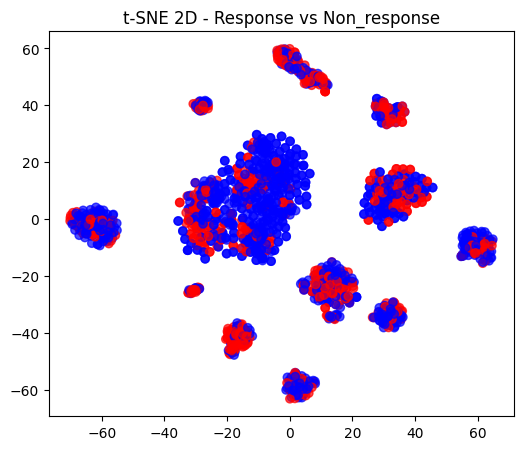

In [20]:
# t-SNE en 2D
tsne2 = TSNE(n_components=2, perplexity=30, random_state=rng_seed)
X_tsne2 = tsne2.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=colors, alpha=0.7)
plt.title("t-SNE 2D - Response vs Non_response")
plt.show()

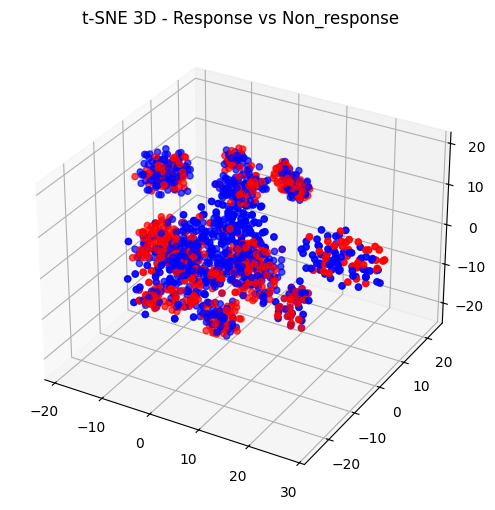

In [21]:
# t-SNE en 3D
tsne3 = TSNE(n_components=3, perplexity=30, random_state=rng_seed)
X_tsne3 = tsne3.fit_transform(X_scaled)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=colors, alpha=0.7)
ax.set_title("t-SNE 3D - Response vs Non_response")
plt.show()

En este caso se distinguen 12 agrupaciones de de naturaleza no lineal en los datos, con niveles de expresión similares. Pero igualmente se observa que todos los clústers contienen una mezcla de datos Response y Non_response, por lo que tampoco se visualiza ninguna tendencia clara de separación de los datos según la clase objetivo.

Es cierto que por cómo trabaja t-SNE, no se conservan las distancias ni estructura globales, así que en cierto modo lo esperado es el resultado obtenido, en el que se muestran claras agrupaciones locales pero no una diferenciación global (responder vs non_responder).

Las mismas razones dadas para el caso PCA podrían explicar estas agrupaciones.

### Exploración de la variabilidad entre genes

In [22]:
# Distribución de varianzas
variances = df[gene_columns].var()
variances.describe()

count    2394.000000
mean        2.882091
std         1.339390
min         0.606610
25%         1.959420
50%         2.636384
75%         3.498915
max        13.403186
dtype: float64

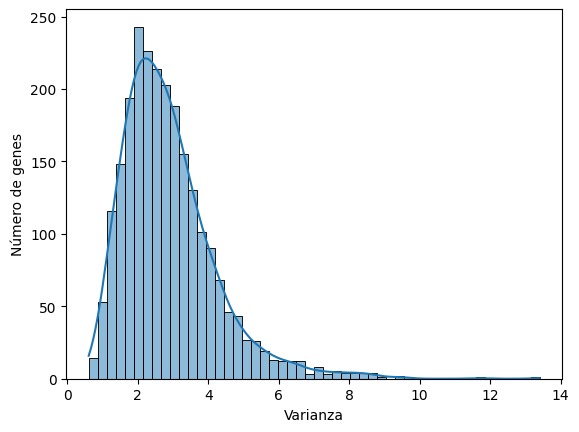

In [23]:
# Histograma de varianzas
sns.histplot(variances, bins=50, kde=True)
plt.xlabel("Varianza")
plt.ylabel("Número de genes")
plt.show()

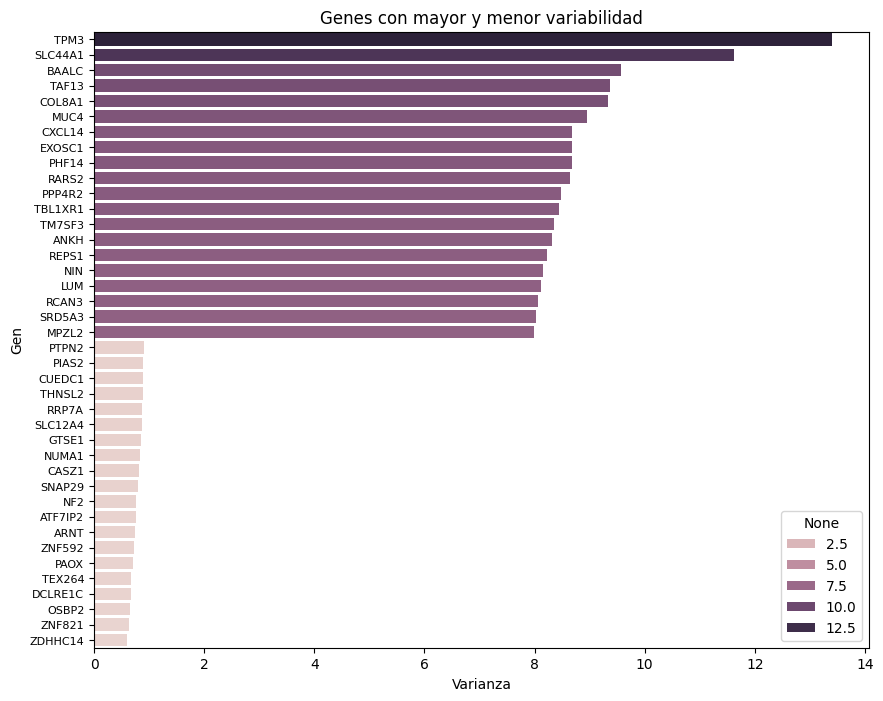

In [24]:
# Genes con mayor y menor variabilidad
top20 = variances.sort_values(ascending=False).head(20)
bottom20 = variances.sort_values(ascending=False).tail(20)
combined = pd.concat([top20, bottom20])

plt.figure(figsize=(10, 8))
sns.barplot(x=combined.values, y=combined.index, hue=combined)
plt.title("Genes con mayor y menor variabilidad")
plt.xlabel("Varianza")
plt.ylabel("Gen")
plt.yticks(fontsize=8)
plt.show()

Se observa que los genes mantienen una expresión relativamente constante con la mayoría con varianzas entre 0 y 5. El 25% de los genes con más variabilidad están por encima de 3.5, lo que es un indicador de dónde podrían estar los genes más relevantes para mantener en el conjunto de datos.

Se observan 2 genes que están significativamente por encima en el top de variabilidad: TPM3 y SLC44A1

En resumen:
* La mayoría de genes muestran variabilidades relativamente bajas < 5
* La mayor dispersión se concentra en menos de un 25% de los genes

In [25]:
# Varianza explicada acumulada (95%)
total_variance = variances.sum()

# Variable para ajustar manualmente y averiguar el 
# top X genes que explican el ~95% de la varianza
X = 2118
top_variance = variances.sort_values(ascending=False).head(X).sum()

# Porcentaje de varianza
percent_explained = (top_variance / total_variance) * 100

print(f"Los {X} genes más variables explican el {percent_explained:.2f}% de la varianza total.")

Los 2118 genes más variables explican el 95.01% de la varianza total.


In [26]:
# Varianza explicada acumulada (top 20)
total_variance = variances.sum()

# Varianza que aportan los 20 genes con mayor varianza
X = 20
top_variance = variances.sort_values(ascending=False).head(X).sum()

# Porcentaje de varianza
percent_explained = (top_variance / total_variance) * 100

print(f"El top 20 de genes más variables explican el {percent_explained:.2f}% de la varianza total.")

El top 20 de genes más variables explican el 2.60% de la varianza total.


El análisis de varianza muestra que la variabilidad génica está ampliamente distribuida: se requieren 2118 genes para explicar el 95% de la varianza total. Los 20 genes más variables sólo representan alrededor del 2,60% de la variabilidad.

Esos números justifican la necesidad de combinar filtrado por varianza con otros tipo de análisis que tengan en cuenta las características biológicas del dataset y la importancia de las características, a la hora de reducir la dimensionalidad a cifras cercanas a la heurística práctica de 20 genes.

**NOTA**: No es estrictamente necesario acercarse a 20 genes, pero en este caso se tratará de aproximar a esa cifra por priorizarse la explicabilidad operativa del modelo final (fácil de interpretar por humanos) y su capacidad de identificación de biomarcadores, en contraposición a la explicabilidad científica que supondría un dataset con muchas más muestras y mayor número de características (difícil de interpretar por humanos).

## 4. Preparación de datos para modelado

### Reducción de la dimensionalidad y filtrado

Como se ha visto hasta ahora, la reducción de dimensionalidad basada sólo en criterios de variabilidad no permite una reducción drástica como la que se plantea (~20 genes).

Por esa razón, se deben incluir criterios de:
* Significancia biológica
* Relaciones complejas entre genes

Para la significancia biológica es habitual en transcriptómica usar análisis de Differentially Expressed Gene (DEG) [http://ctrdb.cloudna.cn/help#AnalysisResult1] y [https://link.springer.com/article/10.1186/s13059-021-02337-8]. DEG es una técnica estadística utilizada en transcriptómica para identificar aquellos genes cuya expresión cambia significativamente entre dos o más condiciones biológicas (por ejemplo, responders contra non_esponders). Su aplicación tiene sentido porque permite distinguir qué genes están asociados a la variabilidad específica de la condición de interés, separando la señal biológica relevante del ruido de la expresión basal. De este modo, el DEG no solo facilita la interpretación funcional de los datos, sino que también aporta candidatos concretos para estudios posteriores de biomarcadores, mecanismos moleculares y posibles dianas terapéuticas.

Para las relaciones complejas se plantea el uso de los algoritmos de modelado que se usarán para entrenar a los modelos finales. Así pues, la idea es crear modelos con el dataset tras la aplicación de DEG, e identificar en varios modelos los genes más importantes, para hacer la selección final.

Con este pipeline se pretende que, aunque la reducción de características final es muy agresiva, se mantenga en la medida de lo posible la mayor cantidad de significancia biológica final.

Así pues esta será la linea de trabajo:

1. Reducción por varianza (top genes que explican ~95%)
2. DEG y selección de umbral de decisión (reducción a 200-500 genes)
3. Selección de características final mediante modelado e importancia de características (~20 genes)

**NOTA**: Las cifras de genes en cada fase son aproximaciones, pero la decisión final se basará en criterios técnicos, como umbrales estadísticos.

**NOTA 2**: Los dos primeros puntos se llevarán a cabo en este apartado de preparación de datos, pero el punto 3 como depende de modelado, se deja para el documento de modelado directamente.

#### Reducción por varianza

En el apartado anterior se ha expuesto que los 2118 con más variabilidad explican el 95% de esta, así que se hace la reducción a ese nivel.

Se aplica primero esta pequeña reducción, en lugar aplicar reducción mediante DEG directamente, para reducir ruido y eliminar genes con poca aportación o expresión muy baja. Eso mejora el análisis DEG.

In [27]:
# Reducción de la dimensionalidad en base a los genes más variables
# que explican el 95% de la varianza

# Se obtienen los nombres de los 2118 genes con más varianza
top_genes = variances.sort_values(ascending=False).head(2118).index

# Se compone un nuevo dataframe con los genes seleccionados
# mantienendo las columnas Sample_id y Response
df_95_variance = pd.concat([df[top_genes], df[["Sample_id", "Response"]]], axis=1)

In [28]:
print(df_95_variance.shape)
df_95_variance.head()

(1889, 2120)


,TPM3,SLC44A1,BAALC,TAF13,COL8A1,MUC4,CXCL14,EXOSC1,PHF14,RARS2,...,TMEM143,IRF5,CLK4,SORBS1,PHKA1,CBX5,CISH,SART1,Sample_id,Response
0,8.702868,5.549792,1.690159,4.711650,6.390634,5.040225,10.521530,5.463255,4.456965,4.350072,...,4.753864,4.786555,5.550572,6.476797,3.152561,9.276035,5.562181,6.832458,GSM1233067,Non_response
1,8.508480,6.148663,1.474050,4.656948,6.910407,6.153527,7.776188,4.850679,4.376095,5.720579,...,5.110588,4.770589,5.601391,7.467051,3.392151,9.974920,5.969267,6.753476,GSM1233069,Non_response
2,8.337148,5.901944,1.540889,5.059497,6.416734,5.311649,7.050184,4.921558,4.598929,6.350793,...,4.595303,4.510853,6.800999,7.058163,3.136206,9.801535,5.648399,6.874352,GSM1233072,Non_response
3,9.097482,5.463462,2.070768,5.879583,4.738622,5.785577,10.210856,5.233729,4.621458,5.325575,...,4.686458,6.067221,4.974420,6.927660,3.773207,10.156168,5.607082,6.218983,GSM1233085,Response
4,8.383548,5.712966,1.854861,4.280837,8.079194,6.675105,4.562917,4.873935,4.097568,5.444436,...,4.362369,5.008466,6.141051,5.994153,3.220420,10.016626,5.271657,6.543586,GSM1233086,Non_response


#### Reducción mediante análisis de DEG

La lógica de DEG es separar la señal biológica relevante del ruido de la expresión base. Los pasos para implementarlo son:

1. Aplicar modelo estadístico para cada gen y obtener sus p-values
2. Aplicar ajuste de p-values mediante FDR (Benjamini-Hochberg) (esto ayuda a reducir los errores de tipo I)
3. Se seleccionan umbrales de significancia estadística y corte

Con el paso 1, se evalúa la diferencia de expresión de cada gen cuando la respuesta es Responder y cuando la respuesta es Non_responder. De este modo se cuantifica la probabilidad de observar diferencias iguales o mayores que puedan ser significativas.

Con el paso 2, se pretende corregir el número de falsos positivos, tratando de mantener un balance entre sensibilidad y especificidad. FDR viene de "False Discovery Rate" y como indica su nombre es un algoritmo que mide la tasa de falsos positivos. Se usa FDR (Benjamini-Hochberg) por ser un estándar en este tipo de procedimientos en transcriptómica y por ser el mismo que la propia base de datos CTR-DB del que procede el dataset utiliza en algunas de las herramientas que proveen [http://ctrdb.cloudna.cn/help#AnalysisResult1]

Con el paso 3 se seleccionan los genes que se considerarán suficientemente significativos. La idea es que un gen puede ser significativo pero teniendo cambios de expresión muy pequeños y sin relevancia biológica, por tanto con estos umbrales se seleccionan los más robustos estadística y biológicamente relevantes. Los umbrales relevantes son:
* **FDR**: Rango entre 0 y 1. Indica la proporción máxima de falsos positivos que aceptamos entre los genes significativos.
* **|log2FC|**: No tiene un rango delimitado. Controla el Fold Change (FC), que es la magnitud mínima de cambio de expresión, que se considera relevante. Un valor bajo incluye genes con cambios más pequeños y sube la sensibilidad, un valor más alto incluye sólo genes con cambios más grandes, lo que aumenta a la espeficidad, a riesgo de perder genes con cambios sutiles pero con importancia.

A nivel técnico |log2FC| mide el cambio de las medias de expresión entre Responder y Non_responder para cada gen (media de expresión responders / media de expresión non_responders) y se expresa en log2. Nuestros datos ya están en log2 por tanto log2FC es la resta de las medias. El umbral se establece para el valor absoluto de esa medida porque lo importante a nivel biológico es la magnitud de la expresión del gen, sea subexpresado (valores negativos) o sobreexpresado (valores positivos).

El modelo estadístico a usar depende de diversos factores, pero para conjuntos de datos como el de este proyecto, que ya está normalizado, transformado a log2 y con un número de muestras de miles se suele recomendar Student (t-test).

In [29]:
# Análisis DEG
# Datos
X = df_95_variance[top_genes]
y = df_95_variance["Response"]

responders = X[y == "Response"]
non_responders = X[y == "Non_response"]

# Paso 1: Modelo estadístico y obtención de p-values gen a gen
pvals = []
log2fc = []

for gene in X.columns:
    # t-test con varianzas desiguales
    stat, p = ttest_ind(responders[gene], non_responders[gene], equal_var=False)
    pvals.append(p)
    
    # Fold Change (FC)
    mean_resp = responders[gene].mean()
    mean_nonresp = non_responders[gene].mean()
    # OJO! Como los datos ya están en log2 (por RMA)
    # log2fc es la resta de las medias
    log2fc.append(mean_resp - mean_nonresp)

results = pd.DataFrame({
    "Gene": X.columns,
    "pval": pvals,
    "log2FC": log2fc
})

# Paso 2: Ajuste de p-values con FDR (Benjamini-Hochberg)
results["FDR"] = multipletests(results["pval"], method="fdr_bh")[1]

# Paso 3: Selección de umbrales para obtener genes significativos
FDR_threshold = 0.05
log2FC_threshold = 0.57
results["Significant"] = (results["FDR"] <= FDR_threshold) & (results["log2FC"].abs() >= log2FC_threshold)

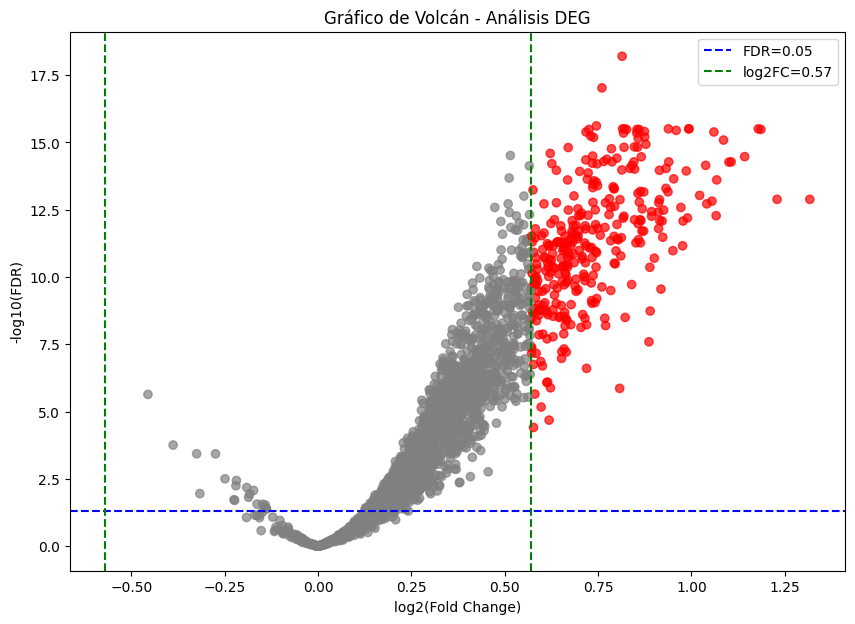

In [30]:
# Volcano plot
plt.figure(figsize=(10,7))
plt.scatter(results["log2FC"], -np.log10(results["FDR"]), 
            c=results["Significant"].map({True:"red", False:"grey"}), alpha=0.7)

plt.axhline(-np.log10(FDR_threshold), color="blue", linestyle="--", label=f"FDR={FDR_threshold}")
plt.axvline(log2FC_threshold, color="green", linestyle="--", label=f"log2FC={log2FC_threshold}")
plt.axvline(-log2FC_threshold, color="green", linestyle="--")

plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(FDR)")
plt.title("Gráfico de Volcán - Análisis DEG")
plt.legend()
plt.show()

In [31]:
# Genes seleccionados con DEG
deg_genes = results[results["Significant"]].sort_values("FDR")
print("Número de genes significativos:", len(deg_genes))
print(deg_genes.head(20))

Número de genes significativos: 323
       Gene          pval    log2FC           FDR  Significant
836   IKZF3  2.962427e-22  0.814246  6.274421e-19         True
808   LYRM2  8.898480e-21  0.760206  9.423490e-18         True
844  CAMK1D  3.438013e-19  0.745441  2.427237e-16         True
82    STMN3  9.977003e-19  0.993529  3.123070e-16         True
383    ASPM  1.207749e-18  0.820488  3.123070e-16         True
143   LIN37  1.327083e-18  0.938229  3.123070e-16         True
394  KLHL36  7.138989e-19  0.815553  3.123070e-16         True
109  ZNF493  1.260917e-18  0.992633  3.123070e-16         True
13     ANKH  9.927659e-19  1.178842  3.123070e-16         True
282  DIAPH3  1.810652e-18  0.854023  3.284095e-16         True
250     SP1  1.703655e-18  0.859567  3.284095e-16         True
382    RFX1  1.981072e-18  0.826236  3.284095e-16         True
860    FKRP  2.170790e-18  0.725512  3.284095e-16         True
8     PHF14  2.020243e-18  1.185823  3.284095e-16         True
138    ETS2  2.5215

En el análisis DEG se observa que, tras aplicar un umbral de FDR ≤ 0.05, todos los genes con diferencias relevantes resultaron altamente significativos, lo que indica una potencia estadística elevada. El rango de log2FC obtenido fue relativamente estrecho (–0.50 a +1.25), reflejando cambios moderados de expresión consistentes con la normalización RMA. Al variar el umbral de log2FC, se comprueba de forma empírica que con ≥0.48 se seleccionan cerca de 500 genes y con ≥0.66 se reducen a alrededor de 200, que corresponde al rango previsto de 200–500 genes para la fase exploratoria.

Con el objetivo de mantener un equilibrio entre sensibilidad y especificidad, se decidió adoptar un punto intermedio entre ambos cortes, estableciendo el umbral en |log2FC| ≥ 0.57. Este criterio arroja 323 genes significativos, un número manejable que preserva la diversidad de cambios moderados sin caer en un exceso de ruido. 

Se ha pretendido hacer la elección de forma no es arbitraria, respondiendo a la necesidad metodológica de trabajar con un conjunto intermedio que permita aplicar selección supervisada, para así identificar de forma robusta y estable los genes candidatos a biomarcador más relevantes.

In [32]:
# Selección de genes más significativos tras el análisis de DEG

# Se obtienen los nombres de los 323 genes más significativos
top_deg_genes = deg_genes["Gene"].tolist()

# Se compone un nuevo dataframe con los genes seleccionados
# mantienendo las columnas Sample_id y Response
df_top_significance = pd.concat([df_95_variance[top_deg_genes], df_95_variance[["Sample_id", "Response"]]], axis=1)

In [33]:
print(df_top_significance.shape)
df_top_significance.head()

(1889, 325)


,IKZF3,LYRM2,CAMK1D,STMN3,ASPM,LIN37,KLHL36,ZNF493,ANKH,DIAPH3,...,LRRC2,EMP1,ILF2,BAALC,FERMT1,COL3A1,GPX2,LUM,Sample_id,Response
0,4.103426,6.068536,4.973394,6.407097,5.143248,4.973046,5.566896,3.969465,6.012642,3.683278,...,1.147487,7.537884,3.616047,1.690159,4.691866,9.065950,5.702240,8.867410,GSM1233067,Non_response
1,3.920655,6.557802,5.801435,7.215808,3.710855,4.719509,5.417109,4.361004,6.090558,2.761323,...,1.393867,7.885971,3.264571,1.474050,4.454362,10.079410,4.867053,8.890513,GSM1233069,Non_response
2,4.481022,6.255427,5.284051,7.006785,5.161936,4.662014,5.082519,4.272467,6.164362,3.393328,...,1.086110,7.469671,3.923432,1.540889,4.638681,9.550941,5.194885,8.952226,GSM1233072,Non_response
3,3.959662,6.591930,4.899338,5.868233,4.059931,5.199380,6.262133,4.234003,7.736309,3.386443,...,1.133003,6.964517,3.551339,2.070768,4.702022,9.516729,5.019933,8.104033,GSM1233085,Response
4,3.560672,6.349895,5.256461,6.499488,5.228279,4.604829,5.913456,4.194718,6.874245,3.016223,...,1.472271,7.746497,3.438505,1.854861,4.364195,10.812143,5.073029,9.979335,GSM1233086,Non_response


#### División del conjunto de datos

El siguiente paso será hacer la selección supervisada, para terminar la selección definitiva de genes a usar. Para eso es necesario ya en este punto dividir el dataset en los subconjuntos de datos pertinentes para llevar a cabo las tareas del presente proyecto.

Se crearán subconjuntos de entrenamiento (con validación cruzada), test y calibración, con vistas al modelado final y la cuantificación de la incertidumbre.

Como disponemos de pocos datos y no queremos un conjunto minúsculo de calibración tomamos las siguientes decisiones:
* Usar validación cruzada (prescindimos de subconjunto explícito de validación y asignamos mayor porcentaje al subconjunto de calibración)
* **Entrenamiento**: 75%
* **Test**: 15%
* **Calibración**: 10%

Además los conjuntos de datos se harán estratificados, para representar la asimetría del conjunto de datos original.

In [39]:
# Separación de subconjuntos estratificados

# Separación Entrenamiento (75%) y Resto (25%)
df_train, df_temp = train_test_split(
    df_top_significance, test_size=0.25, stratify=df_top_significance["Response"], random_state=rng_seed)

# Separación Test y Calibración
# Proporciones Calibración=10% x 25%=0.4 y Test=15% x 25%=0.6
df_cal, df_test = train_test_split(
    df_temp, test_size=0.6, stratify=df_temp["Response"], random_state=rng_seed)

In [40]:
# Resumen de datos de los subconjuntos
pd.DataFrame({
    "Conjunto": ["Original", "Train", "Test", "Calibración"],
    "Total": [
        len(df_top_significance),
        len(df_train),
        len(df_test),
        len(df_cal)
    ],
    "Responder": [
        (df_top_significance["Response"] == "Response").sum(),
        (df_train["Response"] == "Response").sum(),
        (df_test["Response"] == "Response").sum(),
        (df_cal["Response"] == "Response").sum()
    ],
    "Non_Responder": [
        (df_top_significance["Response"] == "Non_response").sum(),
        (df_train["Response"] == "Non_response").sum(),
        (df_test["Response"] == "Non_response").sum(),
        (df_cal["Response"] == "Non_response").sum()
    ]
})

,Conjunto,Total,Responder,Non_Responder
0,Original,1889,704,1185
1,Train,1416,528,888
2,Test,284,106,178
3,Calibración,189,70,119


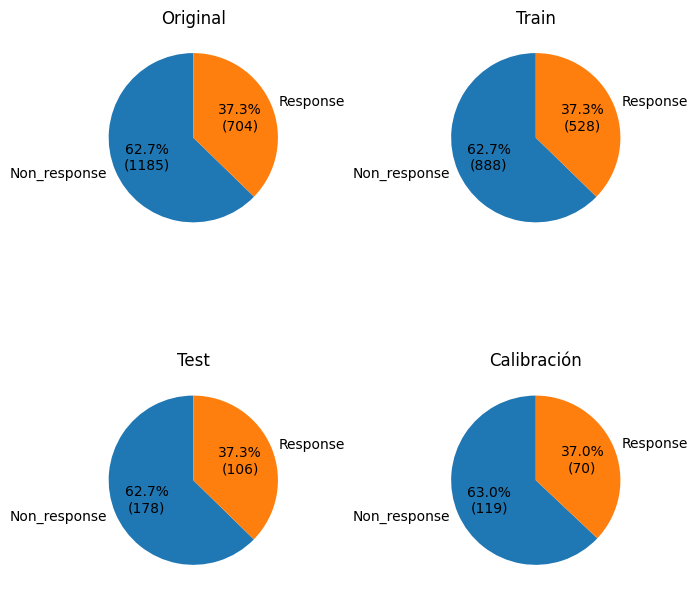

In [37]:
# Gráficos de distribución de clase objetivo en cada subconjunto de datos

# Función para mostrar porcentaje + valor absoluto
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct*total/100.0))
        return f"{pct:.1f}%\n({count})"
    return my_format

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()

# Original
counts_original = df_top_significance["Response"].value_counts()
axes[0].pie(counts_original, labels=counts_original.index,
            autopct=autopct_format(counts_original), startangle=90)
axes[0].set_title("Original")

# Entrenamiento
counts_train = df_train["Response"].value_counts()
axes[1].pie(counts_train, labels=counts_train.index,
            autopct=autopct_format(counts_train), startangle=90)
axes[1].set_title("Train")

# Test
counts_test = df_test["Response"].value_counts()
axes[2].pie(counts_test, labels=counts_test.index,
            autopct=autopct_format(counts_test), startangle=90)
axes[2].set_title("Test")

# Calibración
counts_cal = df_cal["Response"].value_counts()
axes[3].pie(counts_cal, labels=counts_cal.index,
            autopct=autopct_format(counts_cal), startangle=90)
axes[3].set_title("Calibración")

plt.tight_layout()
plt.show()

Para rematar esta parte, guardamos los subconjuntos para usar en el documento de modelado.

In [38]:
# Guardamos los datasets
df_top_significance.to_csv("./data/full_top_significance_dataset.csv", index=False)
df_train.to_csv("./data/train_dataset.csv", index=False)
df_test.to_csv("./data/test_dataset.csv", index=False)
df_cal.to_csv("./data/calibration_dataset.csv", index=False)